In [94]:
import pandas as pd
import numpy as np
import scipy.stats as spstats
import sklearn.metrics as sk_metrics
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
data_df = pd.read_csv('data_swap_nadym.csv', header=0, usecols=['Observed', 'Simulated'], na_values=-999)
data_df.index = pd.date_range('1967-01-01', '1991-12-31', freq='D')
data_df.head()

,Observed,Simulated
1967-01-01,0.3510,0.224
1967-01-02,0.3492,0.220
1967-01-03,0.3492,0.217
1967-01-04,0.3492,0.214
1967-01-05,0.3492,0.210


In [37]:
data_df = data_df.dropna()
simulated = data_df.Simulated.values
observed  = data_df.Observed.values

In [38]:
simulated

array([ 0.224,  0.22 ,  0.217, ...,  0.164,  0.162,  0.16 ])

In [39]:
observed

array([ 0.351 ,  0.3492,  0.3492, ...,  0.378 ,  0.378 ,  0.378 ])

$$NSE = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-\bar{obs})^2}$$

In [90]:
def NS(obs, sim):
    """
    Nash-Sutcliff model efficinecy
    
        .. math::
         NSE = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-\bar{obs})^2} 
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    
    """
    numerator = np.sum( (obs - sim)**2 )
    
    denominator = np.sum( (obs - np.mean(obs))**2 )
    
    return 1 - numerator / denominator

In [62]:
NS(observed, simulated)

0.73982109896950754

$$NSE_{iq} = 1-\frac{\sum_{i=1}^{N}( \frac{1}{obs_{i} + \varepsilon} - \frac{1}{sim_{i} + \varepsilon})^2}{\sum_{i=1}^{N}(\frac{1}{obs_{i} + \varepsilon}-\bar{\frac{1}{obs + \varepsilon}})^2}$$

In [78]:
def NSiq(obs, sim):
    """
    Nash-Sutcliff model efficinecy for inverse transformed flows
    
        .. math::
         NSE_{iq} = 1-\frac{\sum_{i=1}^{N}( \frac{1}{obs_{i} + \varepsilon} - \frac{1}{sim_{i} + \varepsilon})^2}{\sum_{i=1}^{N}(\frac{1}{obs_{i} + \varepsilon}-\bar{\frac{1}{obs_{i} + \varepsilon}})^2} 
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: Nash-Sutcliff model efficiency for inverse transformed flows
    :rtype: float
    
    """
    # add small constant for zero values avoiding
    obs = obs + 0.01 * obs.mean()
    sim = sim + 0.01 * sim.mean()
    
    # flows inverse transformation
    obs_iq = 1 / obs
    sim_iq = 1 / sim
    
    numerator = np.sum( (obs_iq - sim_iq)**2 )
    
    denominator = np.sum( ( obs_iq - np.mean(obs_iq) )**2 )
    
    return 1 - numerator / denominator

In [84]:
NSiq(observed, simulated)

-13.085051422272374

$$KGE' = 1 - \sqrt{ (r-1)^{2} + (\beta-1)^{2} + (\gamma-1)^{2}}$$

$$\beta = \frac{\mu_{sim}}{\mu_{obs}} $$

$$\gamma = \frac{ \sigma_{sim} / \mu_{sim} }{ \sigma_{obs} / \mu_{obs} }$$


$\mu$ - mean runoff;

$\sigma$ - standart deviation;

$r$ - correlation coefficient.

In [87]:
def KGE(obs, sim):
    """
    Modified Kling-Gupta Efficiency
    
        ..math::
            $$KGE' = 1 - \sqrt{ (r-1)^{2} + (\beta-1)^{2} + (\gamma-1)^{2}}$$

            $$\beta = \frac{\mu_{sim}}{\mu_{obs}} $$

            $$\gamma = \frac{ \sigma_{sim} / \mu_{sim} }{ \sigma_{obs} / \mu_{obs} }$$


            $\mu$ - mean runoff;

            $\sigma$ - standart deviation;

            $r$ - correlation coefficient.
    
    Article: 
    Kling, H., Fuchs, M., Paulin, M., 2012. Runoff conditions in the upper Danube basin under an ensemble of climate change scenarios. J. Hydrol. 424–425, 264–277. doi:10.1016/j.jhydrol.2012.01.011
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: Modified Kling-Gupta Efficiency
    :rtype: float
            
    """
    r     = np.corrcoef(obs, sim)[0,1]
    beta  = sim.mean() / obs.mean()
    gamma = ( sim.std() / sim.mean() ) / ( obs.std() / obs.mean() )
    
    kge   = 1 - np.sqrt( (r-1)**2 + (beta-1)**2 + (gamma-1)**2 )
        
    return kge

In [88]:
KGE(observed, simulated)

0.84180450325050205

$$Bias = \frac{1}{N}\sum_{i=1}^{N}(obs_{i}-sim_{i})$$

In [63]:
def bias(obs, sim):
    """
    Bias
    
        .. math::
          Bias=\frac{1}{N}\sum_{i=1}^{N}(obs_{i}-sim_{i})
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: Bias
    :rtype: float
    """
    return np.sum(obs - sim) / obs.size

In [64]:
bias(observed, simulated)

0.054928191150442479

$$PBias= 100 * \frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})}{\sum_{i=1}^{N}(obs_{i})} \%$$

In [65]:
def pbias(obs, sim):
    """
    Bias percentage
    
        .. math::
          $$PBias= 100 * \frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})}{\sum_{i=1}^{N}(obs_{i})} \%$$
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: PBias
    :rtype: float
    """
    return 100 * ( np.sum(obs - sim) / np.sum(obs) )

In [66]:
pbias(observed, simulated)

6.5970680273963858

$$ $$

In [198]:
def fdc(series, interval=[0, 1], plot=False):    
    """
    FDC (flow duration curve) coordinates calculation
    
    source:
    http://pubs.usgs.gov/wsp/1542a/report.pdf
    
    :series: flow series
    :type: numpy array
    
    :interval: probability interval
    :type: list with floats - min and max of probability
    :default: [0, 1] - whole curve
    
    :plot: if True - plot simple FDC
    :type: boolean
    :default: False
    
    :return: probabilities, ascending sorted series
    :rtype: numpy arrays
    """  
    
    series = np.sort(series)
    
    # ranks data from smallest to largest
    ranks = spstats.rankdata(series)

    # reverses rank order
    ranks = ranks[::-1]
    
    # calculate probability of each rank
    prob = np.array([ ( ranks[i] / (len(series)+1) ) for i in range( len(series) ) ])
    
    mask = (interval[0] < prob) & (prob < interval[1]) 
    
    if plot == True:
        plt.plot(prob[mask], series[mask])
    
    return prob[mask], series[mask]

(array([  9.99882020e-01,   9.99764040e-01,   9.99646059e-01, ...,
          4.12930628e-04,   1.76970269e-04,   1.76970269e-04]),
 array([  0.12204,   0.12204,   0.12222, ...,  10.71   ,  10.926  ,  12.06   ]))

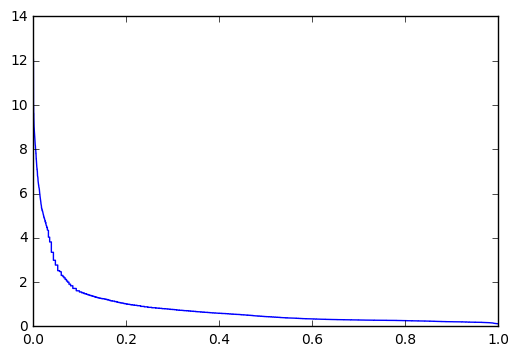

In [199]:
fdc(observed, plot=True)

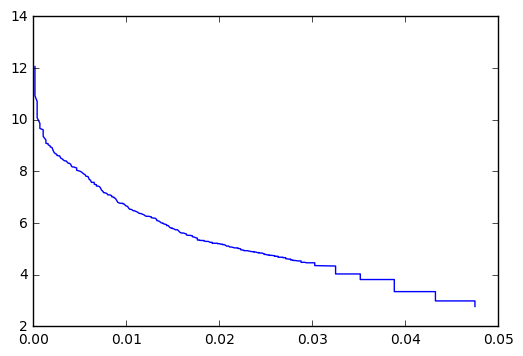

In [202]:
_, _ = fdc(observed, interval=[0, 0.05], plot=True)

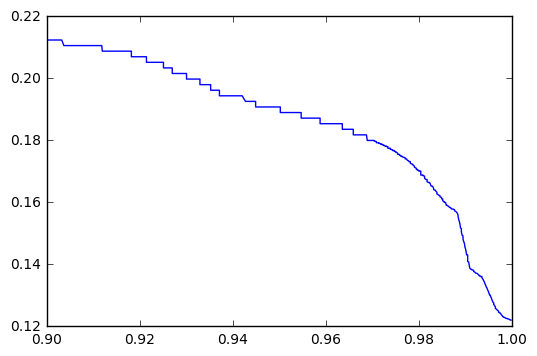

In [203]:
_, _ = fdc(observed, interval=[0.9, 1], plot=True)

$$\Delta FHV = 100 * \frac{\sum_{h=1}^{H}(sim_{h}-obs_{h})}{\sum_{h=1}^{H}(obs_{h})} \%$$
$h = 1, 2, ...H$ - flow indices for flows with exceedance probabilities lower than 0.05

In [208]:
def FHV5(obs, sim):
    """
    FHV5 is a bias in FDC high-segment volume (0-5%)
    
        .. math::
          $$\Delta FHV = 100 * \frac{\sum_{h=1}^{H}(sim_{h}-obs_{h})}{\sum_{h=1}^{H}(obs_{h})} \%$$
          $h = 1, 2, ...H$ - flow indices for flows with exceedance probabilities lower than 0.05
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: FHV5
    :rtype: float
    """
    # implement fdc() function for flows slicing from 0-5%
    obs_sorted = fdc(obs, interval=[0, 0.05])[1]
    sim_sorted = fdc(sim, interval=[0, 0.05])[1]
    
    # lenght of sorted flow arrays may not match
    # we need to cut arrays for minimum length of both
    min_lenght = min(obs_sorted.size, sim_sorted.size)
    
    obs_sorted = obs_sorted[: min_lenght]
    sim_sorted = sim_sorted[: min_lenght]
    
    FHV5 = 100 * ( np.sum( sim_sorted - obs_sorted ) / np.sum(obs_sorted) )
    
    return FHV5

In [209]:
FHV5(observed, simulated)

-7.8810254323896833

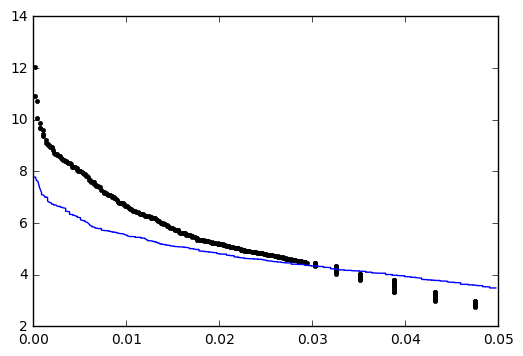

In [216]:
probao5, observed5 = fdc(observed, interval=[0, 0.05])
probas5, simulated5 = fdc(simulated, interval=[0, 0.05])

plt.plot(probao5, observed5, 'k.',
         probas5, simulated5, 'b-')

$$\Delta FLV = -100 * \frac{ \sum_{l=1}^{L}[ log(sim_{l}) - log(sim_{L}) ] - \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] }{ \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] } \%$$

$l = 1, 2, ...L$ - index of the flow value located within the low-flow segment (0.7–1.0 flow exceedance probabilities) of the flow duration curve, L being the index of the minimum flow.

In [223]:
def FLV70(obs, sim):
    """
    FLV70 is a bias in FDC low-segment volume (> 70%)
    
        .. math::
          $$\Delta FLV = -100 * \frac{ \sum_{l=1}^{L}[ log(sim_{l}) - log(sim_{L}) ] - \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] }{ \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] } \%$$

          $l = 1, 2, ...L$ - index of the flow value located within the low-flow segment (0.7–1.0 flow exceedance probabilities) of the flow duration curve, L being the index of the minimum flow.
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: FLV70
    :rtype: float
    
    """
    # implement fdc() function for flows slicing from 70-100%
    obs_sorted = fdc(obs, interval=[0.7, 1])[1]
    sim_sorted = fdc(sim, interval=[0.7, 1])[1]
    
    # lenght of sorted flow arrays may not match
    # we need to cut arrays for minimum length of both
    min_lenght = min(obs_sorted.size, sim_sorted.size)
    
    obs_sorted = obs_sorted[: min_lenght]
    sim_sorted = sim_sorted[: min_lenght]
    
    # log-transform flow values
    obs_log = np.log(obs_sorted)
    sim_log = np.log(sim_sorted)
    
    numerator = np.sum(sim_log - sim_log[0]) - np.sum(obs_log - obs_log[0])
    
    denominator = np.sum(obs_log - obs_log[0])
        
    FLV70 = -100 * (numerator / denominator)
    
    return FLV70

def FLV90(obs, sim):
    """
    FLV90 is a bias in FDC low-segment volume (> 90%)
    
        .. math::
          $$\Delta FLV = -100 * \frac{ \sum_{l=1}^{L}[ log(sim_{l}) - log(sim_{L}) ] - \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] }{ \sum_{l=1}^{L}[ log(obs_{l}) - log(obs_{L}) ] } \%$$

          $l = 1, 2, ...L$ - index of the flow value located within the low-flow segment (0.7–1.0 flow exceedance probabilities) of the flow duration curve, L being the index of the minimum flow.
    
    :observaliton: Observed data
    :type: numpy array
    
    :simulation: Simulated data
    :type: numpy array
    
    :return: FLV70
    :rtype: float
    
    """
    # implement fdc() function for flows slicing from 70-100%
    obs_sorted = fdc(obs, interval=[0.9, 1])[1]
    sim_sorted = fdc(sim, interval=[0.9, 1])[1]
    
    # lenght of sorted flow arrays may not match
    # we need to cut arrays for minimum length of both
    min_lenght = min(obs_sorted.size, sim_sorted.size)
    
    obs_sorted = obs_sorted[: min_lenght]
    sim_sorted = sim_sorted[: min_lenght]
    
    # log-transform flow values
    obs_log = np.log(obs_sorted)
    sim_log = np.log(sim_sorted)
    
    numerator = np.sum(sim_log - sim_log[0]) - np.sum(obs_log - obs_log[0])
    
    denominator = np.sum(obs_log - obs_log[0])
        
    FLV90 = -100 * (numerator / denominator)
    
    return FLV90

In [221]:
FLV70(observed, simulated)

-18.176018709980632

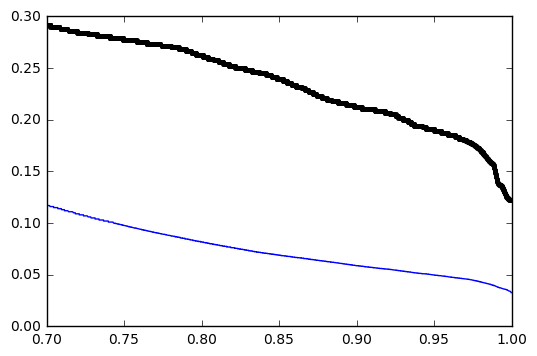

In [222]:
probao70, observed70 = fdc(observed, interval=[0.7, 1])
probas70, simulated70 = fdc(simulated, interval=[0.7, 1])

plt.plot(probao70, observed70, 'k.',
         probas70, simulated70, 'b-')

In [224]:
FLV90(observed, simulated)

3.451904073954005

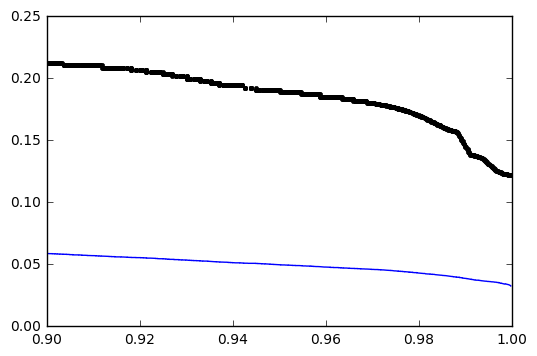

In [225]:
probao90, observed90 = fdc(observed, interval=[0.9, 1])
probas90, simulated90 = fdc(simulated, interval=[0.9, 1])

plt.plot(probao90, observed90, 'k.',
         probas90, simulated90, 'b-')